In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('F:\\Datasets\\Frozen_Dessert_Production.csv',parse_dates=True,index_col='DATE')

In [3]:
df.head()

,IPN31152N
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636


In [4]:
df.columns = ['Production']

In [5]:
df.head()

,Production
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636


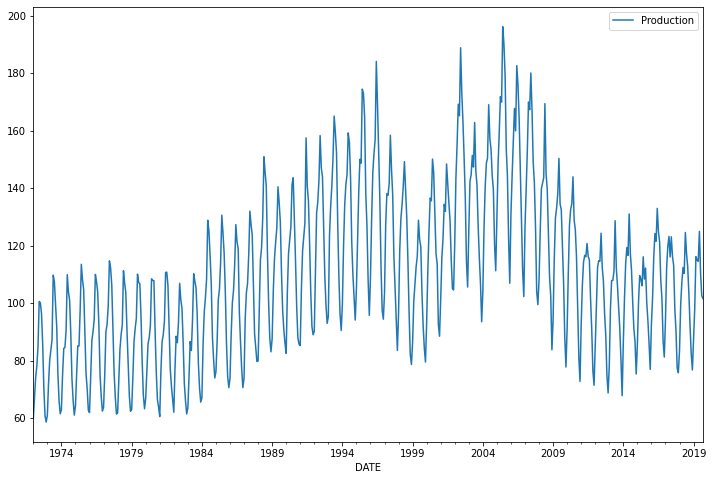

In [6]:
df.plot(figsize=(12,8))

In [7]:
len(df)

573

In [8]:
test_index = len(df) - 24

In [9]:
train = df.iloc[:test_index]

In [10]:
test = df.iloc[test_index:]

In [11]:
len(test)

24

In [12]:
from sklearn.preprocessing import MinMaxScaler

In [13]:
scaler = MinMaxScaler()

In [14]:
scaled_train = scaler.fit_transform(train)

In [15]:
scaled_test = scaler.transform(test)

In [16]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [17]:
generator = TimeseriesGenerator(scaled_train,scaled_train,length=18,batch_size=1)

In [18]:
validation_generator = TimeseriesGenerator(scaled_test,scaled_test,length=18,batch_size=1)

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM
from tensorflow.keras.callbacks import EarlyStopping

In [20]:
model = Sequential()
model.add(LSTM(100,activation='relu',input_shape=(18,1)))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [22]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [23]:
model.fit_generator(generator,validation_data=validation_generator,epochs=20,callbacks=[early_stop])

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 531 steps, validate for 6 steps
Epoch 1/20
531/531 [==============================] - 10s 19ms/step - loss: 0.0258 - val_loss: 0.0047

In [24]:
losses = pd.DataFrame(model.history.history)

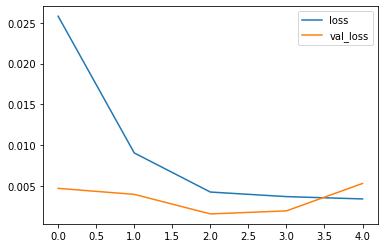

In [25]:
losses.plot()

In [26]:
forecast = []
first_eval_batch = scaled_train[-18:]
current_batch = first_eval_batch.reshape(1,18,1)
for i in range(24):
    pred = model.predict(current_batch)[0]
    forecast.append(pred)
    current_batch = np.append(current_batch[:,1:,:],[[pred]],axis=1)

In [27]:
test["Predictions"] = scaler.inverse_transform(forecast)

C:\Users\aritr\anaconda3\envs\Tensorflow\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [28]:
test

,Production,Predictions
DATE,,
2017-10-01,90.4732,94.190223
2017-11-01,77.4378,88.005790
2017-12-01,75.8118,87.362041
2018-01-01,83.4343,97.314786
2018-02-01,99.4899,110.553388
2018-03-01,107.3152,120.177056
2018-04-01,112.4309,128.216873
2018-05-01,110.3544,133.780266
2018-06-01,124.5841,135.337029


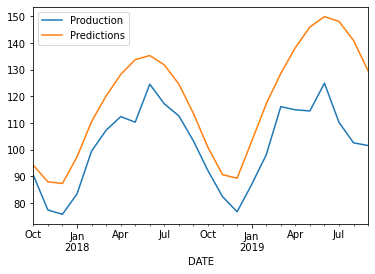

In [29]:
test.plot()

In [30]:
from sklearn.metrics import mean_squared_error

In [31]:
np.sqrt(mean_squared_error(test['Production'],test['Predictions']))

19.409354350130386